# FORECASTING MELI COSTS USING FACEBOOK PROPHET

[Prophet](https://facebook.github.io/prophet/docs/quick_start.html) is a Python library developed by Facebook to do time series analysis and forecasting.

At its core, the Prophet procedure is an [additive regression model](https://en.wikipedia.org/wiki/Additive_model) with three main components: trend, seasonality and holidays. This decomposable model is laid out as

$$y(t) = g(t) + s(t) + h(t) + \epsilon_t \,,$$ 

where $g(t)$ is the trend function (linear or logistic) which models non-periodic changes in the values of the time series, $s(t)$ represents periodic changes (e.g. weekly, monthly or yearly seasonality), and $h(t)$ represents the effects on holidays which occur on potentially irregular schedules over one or more days. The error term $\epsilon_t$ represents changes not accomodated bby the model and will be considered to be normally distributed. 

For further readings, see the original [paper](https://peerj.com/preprints/3190.pdf) or go to Facebook research [blog].

## PREAMBLE

### PACKAGES

In [1]:
import os # for handling files
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings # for handling warning messages
warnings.filterwarnings("ignore")
import numpy as np
from fbprophet import Prophet
import pandas as pd
import statsmodels.api as sm # statistics package
'''
provides classes and functions for the estimation of many different
statistical models, as well as for conducting statistical tests, 
and statistical data exploration.
'''

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

ModuleNotFoundError: No module named 'fbprophet'

## DATA PRE-PROCESSING
### LOADING

In [36]:
os.chdir('/Users/homocuadratus/Google Drive/DATA SCIENCE/CHALLENGES/MELI CHALLENGE/TIME SERIES/')
# adapt filepath to point to the folder .xlsx file is
costs_raw = os.path.abspath("meli_ec2_blended_cost_may_2019.xlsx")
df_costs = pd.read_excel(costs_raw)

### INDEXING 

We use time data as an index for our dataframe

In [37]:
df_costs = df_costs.set_index('ds')

### RESAMPLING 
We resample data using an average daily frequency

In [38]:
df_costs_monthly = df_costs['y'].resample('D').mean()

## DATA VISUALIZATION

### EXPLORATORY VISUALIZATION

We make an exploratory visulization of data using pyplot

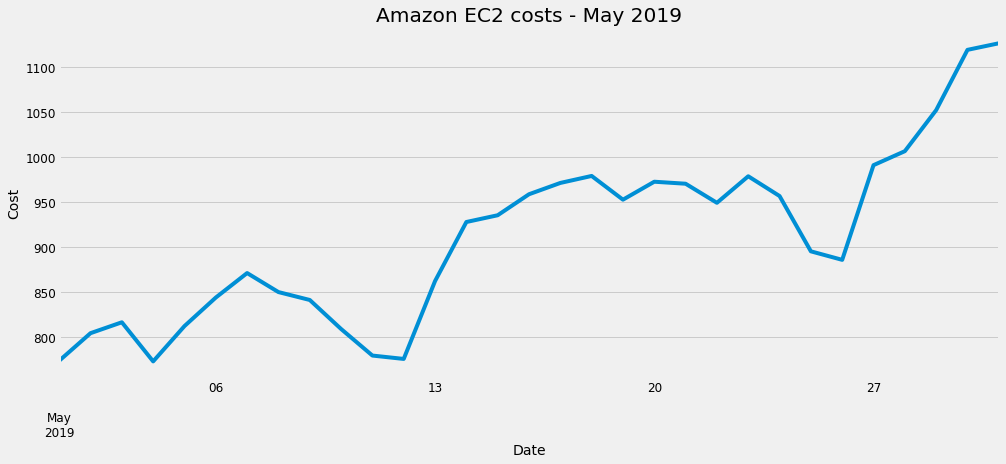

In [39]:
pd.plotting.register_matplotlib_converters()

df_costs_monthly.plot(figsize=(15, 6))
plt.title('Amazon EC2 costs - May 2019')
plt.xlabel('Date')
plt.ylabel('Cost')
#plt.legend()
plt.show()

### STATSMODEL DECOMPOSITION

To gain further insight on how our data behaves, we perform a decomposition plot using time series analysis (tsa) module from statsmodel package 

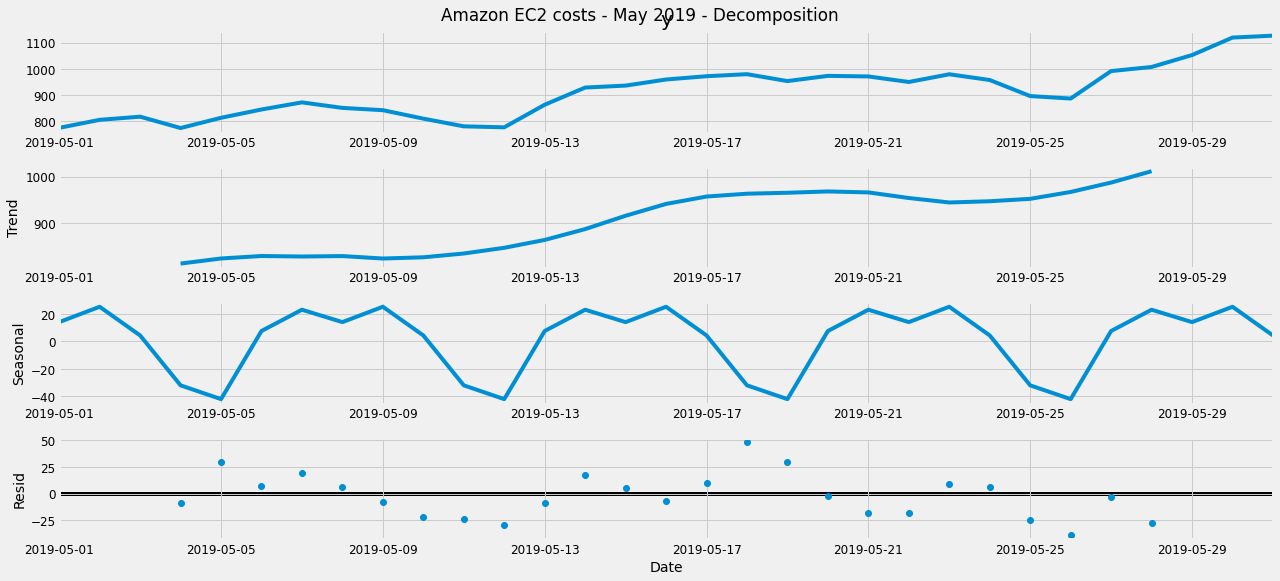

In [40]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(df_costs_monthly, model='additive')
fig = decomposition.plot()
plt.xlabel('Date')
fig.suptitle('Amazon EC2 costs - May 2019 - Decomposition')
plt.show()

## FORECASTING PROCESS

### MODEL INITIALIZATION

We initialize the model and set its parameters accordinlgy. A nice discussion on how to configure them can be seen here

https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3

In [41]:
prophet = Prophet(weekly_seasonality = True,
                  n_changepoints = 3, # a value of 4 better adjusts prior results, but increases the noise level of predictions
                  changepoint_prior_scale = 30,
                  seasonality_mode = 'additive',
                  #seasonality_prior_scale = 30,
                  growth = 'linear')

### MODEL FITTING

Prophet uses a fitter method as any other object belonging to a sklearn environment. 

As we changed df_costs_monthly index to do the exploratory analysis of data, we have to reinstall the original one 

In [42]:
df_costs_monthly = df_costs_monthly.reset_index()

and then do the fitting

In [43]:
prophet.fit(df_costs_monthly)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### FORECAST

Once the model has been fitted, we make a dataset to store future predictions with output frequency equal to "periods"

In [44]:
future = prophet.make_future_dataframe(periods=14)

and then we use the predict method to make our forecast

In [45]:
forecast = prophet.predict(future)

#### RESULTS

Text(0.5, 1.0, 'Costs - 2-weeks forecast')

<Figure size 1296x432 with 0 Axes>

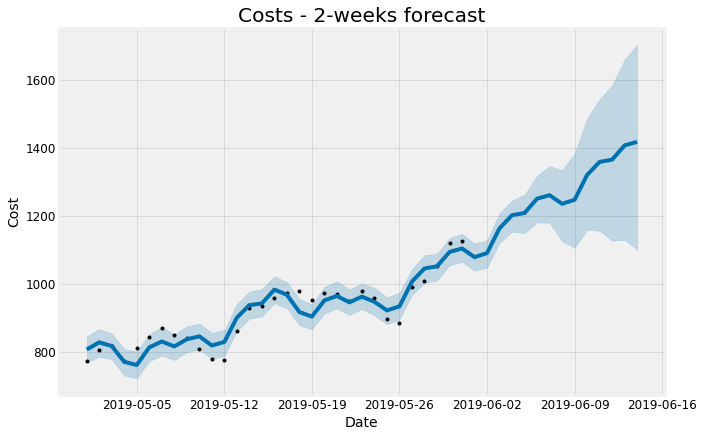

In [46]:
plt.figure(figsize=(18, 6))
prophet.plot(forecast, xlabel = 'Date', ylabel = 'Cost')
plt.title('Costs - 2-weeks forecast')

### ASSESSMENT OF THE MODEL

#### METRICS

The usual definition of the **error** made when we try to forecast a certain value is

$$e_t = \hat{y}_t - y_t\,,$$

where $\hat{y}_t$ is the forecasted value of the actual value $y_t$. As we can see,$e_t$ might be positive, negative or even zero.

Built on top of this definition lay several metrics to assess the accuracy of the model. In the case at hand, we will be be analyzing four of them. Each has its strengths and its pitfalls. Whether we use one or another, depends on the case at hand.

**Bias**

$$Bias = \frac{1}{n} \sum_{t=1}^n \hat{y}_t - y_t\,.$$

Bias is the average error. It can tells us about how accurate the model is, but it gives us no information about model's precision.

**Mean Absolute Error (MAE)**

$$MAE = \frac{1}{n} \sum_{t=1}^n |\hat{y}_t - y_t|\,.$$

MAE is the average absolute error. 

It's another good estimator of model's accuracy and the right metric to minimize if we are trying to aim our forecast to the **median**.

**Mean Absolute Percentage Error (MAPE)**

$$MAPE = \frac{1}{n} \sum_{t=1}^n \frac{|\hat{y}_t - y_t|}{|y_t|}\,.$$

MAPE is the average of absolute percentage error.

It is one of the most commonly used metrics to measure forecast.

**Root Mean Squared Error**

$$RMSE = \sqrt{ \frac{1}{n} \sum_{t=1}^n ( \hat{y}_t - y_t )^2 }\,.$$

RMSE is the square root of the average squared error. 

Compared to MAE, RMSE doesn't treat each error the same. It gives more importance to the most significant errors and that makes RMSE more sensitive to outliers.

RMSE is the right metric to minimize if we are trying to aim our forecast to the **mean**.

To see more on this, read Data Science for Supply Chain Forecast [book](https://www.researchgate.net/publication/334031240_Data_Science_for_Supply_Chain_Forecast). 

#### PREPROCESSING

As we can see, the forecast dataframe does not contain the historical data on it 


In [47]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

We will have to expand it. For doing that we define

In [48]:
def extend_forecast_df(forecast, historical):
    """Extends forecast dataset by adding an 'y' column with historical data.

       Returns forecast dataset with col 'y' added.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [49]:
extended_forecast = extend_forecast_df(forecast, df_costs_monthly)

In [50]:
extended_forecast.head(3)

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2019-05-01,806.971796,768.899473,845.176168,774.111453
2019-05-02,828.009715,786.246526,867.363511,804.738605
2019-05-03,817.125867,777.945629,854.090134,816.846227


In [51]:
extended_forecast.tail(3)

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2019-06-12,1365.023618,1126.779966,1583.866196,NaN
2019-06-13,1407.167077,1129.154116,1659.402091,NaN
2019-06-14,1417.388768,1100.794592,1702.981674,NaN


Now that we have built the extended dataframe, we define a function to calculate the metrics.

In [56]:
def calculate_forecast_errors(extended_forecast_df, periods):
    """Assess a certain forecasting model by calculating Bias, MAE, MAPE, RMSE
       Returns Bias, MAE, MAPE and RMSE

       Args:
           extended_forecast_df: forecast dataframe extended joined with historical data
           periods: amount of periods forecasted
    """
    
    extended_forecast_df = extended_forecast_df.copy()
    
    # we add error and relative_error columns to a copy of the extended_forecast dataframe  
    extended_forecast_df['error'] = extended_forecast_df['yhat'] - extended_forecast_df['y']
    extended_forecast_df['relative_error'] = extended_forecast_df['error'] / extended_forecast_df['y']
    
    
    # we drop future data 
    predicted_history = extended_forecast_df[:-periods]
    
    bias = np.around(np.mean(predicted_history['error']),3)
    mae = np.around(np.mean(np.abs(predicted_history['error'])),3)
    mape = np.around(np.mean(np.abs(predicted_history['relative_error'])),3)
    rmse = np.around(np.sqrt(np.mean(np.power(predicted_history['error'],2))),3)

    return {'Bias': bias, 'MAE': mae, 'MAPE': mape, 'RMSE': rmse}

#### ASSESSMENT RESULTS

In [57]:
print('The model employed to do the forecast has: \n')
for err_name, err_value in calculate_forecast_errors(extended_forecast, 14).items():
    print(err_name, err_value)

The model employed to do the forecast has: 

Bias -0.001
MAE 25.104
MAPE 0.028
RMSE 30.55
